# **E. coli Protein PCA & ADASYN Implementation**

Dataset Ecoli berisi beberapa fitur numerik yang menggambarkan karakteristik protein, dan sebuah label kelas yang menunjukkan lokasi subselular protein tersebut (misalnya cp, im, om, dll).

Analisis ini menggunakan dua metode reduksi dimensi:
- Principal Component Analysis (PCA)
- Linear Discriminant Analysis (LDA)

Keduanya digunakan untuk memproyeksikan **data berdimensi tinggi** (7 fitur) ke dalam ruang dua dimensi, sehingga distribusi data antar kelas dapat divisualisasikan.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sqlalchemy import create_engine
from imblearn.over_sampling import SMOTE
import numpy as np

# === KONEKSI KE MYSQL ===
engine = create_engine("mysql+pymysql://root:@localhost/ecoli")

# === AMBIL DATA ===
df = pd.read_sql("SELECT * FROM ecoli", engine)

# tampilkan 5 baris pertama
print(df.head())

# === PISAHKAN FITUR DAN LABEL ===
X = df[["feature1","feature2","feature3","feature4","feature5","feature6","feature7"]].values
y_raw = df["class_label"].values

# encode label
le = LabelEncoder()
y = le.fit_transform(y_raw)
target_names = le.classes_

# === PCA DATA ASLI ===
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

# === PLOT DATA ASLI ===
plt.figure(figsize=(7,5))
colors = ["navy","turquoise","darkorange","green","red","purple","brown","gray"]
for color, i, target_name in zip(colors, range(len(target_names)), target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=0.8, label=target_name)

plt.legend(loc="best")
plt.title("PCA of Original Ecoli dataset")
plt.show()

unique, counts = np.unique(y, return_counts=True)
print("Distribusi kelas sebelum balancing:", dict(zip(le.classes_, counts)))

# === SMOTE untuk penyeimbangan data ===    
smote = SMOTE(random_state=42, k_neighbors=1)
X_res, y_res = smote.fit_resample(X, y)

print("Jumlah sampel sebelum balancing:", len(y))
print("Jumlah sampel sesudah balancing:", len(y_res))

# identifikasi mana data synthetic
n_original = len(X)
is_synthetic = np.array([False]*n_original + [True]*(len(X_res)-n_original))

# === PCA DATA BALANCED ===
X_r_bal = pca.fit(X_res).transform(X_res)

# === PLOT DATA BALANCED ===
plt.figure(figsize=(7,5))
for color, i, target_name in zip(colors, range(len(target_names)), target_names):
    # titik asli
    plt.scatter(
        X_r_bal[(y_res == i) & (is_synthetic == False), 0],
        X_r_bal[(y_res == i) & (is_synthetic == False), 1],
        color=color, alpha=0.6, label=f"{target_name} (original)"
    )
    # titik synthetic
    plt.scatter(
        X_r_bal[(y_res == i) & (is_synthetic == True), 0],
        X_r_bal[(y_res == i) & (is_synthetic == True), 1],
        color=color, alpha=0.6, marker="x", label=f"{target_name} (synthetic)"
    )

plt.legend(loc="best", fontsize=8)
plt.title("PCA of Balanced Ecoli dataset (SMOTE)")
plt.show()


OperationalError: (pymysql.err.OperationalError) (2003, "Can't connect to MySQL server on 'localhost' ([WinError 10061] No connection could be made because the target machine actively refused it)")
(Background on this error at: https://sqlalche.me/e/20/e3q8)

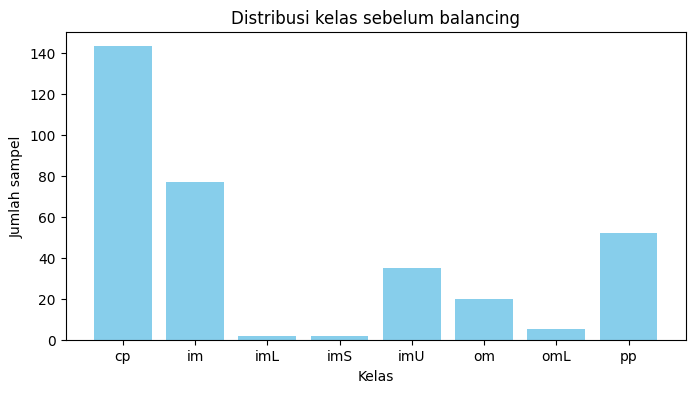

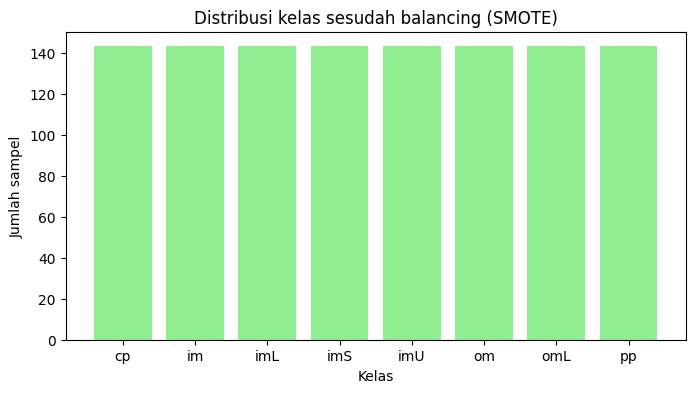

In [ ]:
# hitung distribusi sebelum balancing
unique, counts = np.unique(y, return_counts=True)
dist_before = dict(zip(le.inverse_transform(unique), counts))

# hitung distribusi sesudah balancing
unique_res, counts_res = np.unique(y_res, return_counts=True)
dist_after = dict(zip(le.inverse_transform(unique_res), counts_res))

# === DIAGRAM DISTRIBUSI KELAS SEBELUM BALANCING ===
plt.figure(figsize=(8,4))
plt.bar(dist_before.keys(), dist_before.values(), color="skyblue")
plt.title("Distribusi kelas sebelum balancing")
plt.xlabel("Kelas")
plt.ylabel("Jumlah sampel")
plt.show()

# === DIAGRAM DISTRIBUSI KELAS SESUDAH BALANCING ===
plt.figure(figsize=(8,4))
plt.bar(dist_after.keys(), dist_after.values(), color="lightgreen")
plt.title("Distribusi kelas sesudah balancing (SMOTE)")
plt.xlabel("Kelas")
plt.ylabel("Jumlah sampel")
plt.show()


## **Detail**

Dataset Ecoli yang digunakan memiliki distribusi kelas yang **sangat tidak seimbang**. Sebagai contoh, beberapa kelas **minoritas ekstrem hanya memiliki 2–5 sampel**, sedangkan kelas **mayoritas memiliki lebih dari 100 sampel**: **{'cp': 143, 'im': 77, 'imL': 2, 'imS': 2, 'imU': 35, 'om': 20, 'omL': 5, 'pp': 52}**

Penyeimbangan data dicoba menggunakan ADASYN, karena metode ini dapat membuat sampel synthetic yang fokus pada titik-titik minoritas yang sulit dipelajari (***hard-to-learn***). Namun, **ADASYN memerlukan jumlah sampel minoritas minimal 3** untuk mencari tetangga dari kelas mayoritas.

Dalam dataset ini, kelas **imL dan imS hanya memiliki 2 sampel**, sehingga **ADASYN gagal mengeksekusi proses** penyeimbangan dan menghasilkan error:

"RuntimeError: Not any neighbours belong to the majority class..."

Untuk mengatasi hal ini, dipilih **SMOTE (Synthetic Minority Over-sampling Technique)** sebagai metode penyeimbangan. SMOTE tetap bisa bekerja untuk kelas minoritas yang sangat kecil dengan cara:
- Membuat sampel synthetic dengan menginterpolasi antara titik minoritas dan tetangga terdekatnya.
- Memungkinkan pengaturan k_neighbors secara manual, sehingga dapat disesuaikan dengan jumlah sampel minoritas (dalam kasus ini, k_neighbors=1).
- Dengan SMOTE, semua kelas minoritas, termasuk yang memiliki sangat sedikit sampel, dapat dibuatkan sampel synthetic dengan aman tanpa error, sehingga dataset menjadi lebih seimbang dan siap untuk analisis atau pemodelan berikutnya.

**Hasilnya**, distribusi kelas menjadi sepenuhnya seimbang, di mana setiap kelas memiliki jumlah sampel yang sama (143 sampel per kelas). Diagram distribusi sesudah balancing menunjukkan bahwa semua kelas kini memiliki representasi yang setara, sehingga dataset lebih siap digunakan untuk analisis dan pemodelan.

## **Kesimpulan** :

1. **Distribusi Kelas Sangat Tidak Seimbang (Imbalanced Dataset)**
- Dari data awal terlihat bahwa kelas mayoritas **(cp = 143)** jauh lebih **dominan** dibanding kelas **minoritas** ekstrem **(imL = 2, imS = 2, omL = 5)**.
- Ketidakseimbangan ini berpotensi besar menyebabkan model machine learning bias ke kelas mayoritas.

2. **Keterbatasan ADASYN**
- ADASYN gagal diterapkan karena kelas dengan jumlah sampel < 3 (misalnya imL dan imS).
- Error terjadi karena algoritma butuh minimal beberapa tetangga untuk interpolasi.

3. **Solusi dengan SMOTE (k_neighbors=1)**
- SMOTE berhasil diterapkan karena memungkinkan interpolasi dengan hanya satu tetangga.
- Hal ini membuat kelas minoritas dengan hanya 2–5 sampel tetap bisa diperbanyak tanpa error.

4. **Perubahan Distribusi Kelas**
- Jumlah data bertambah dari 336 → 1144 sampel.
- Semua kelas diseimbangkan, sehingga dataset menjadi lebih representatif untuk pelatihan model.

5. **Hasil PCA (Principal Component Analysis)**
- Sebelum balancing (gambar 1): titik data minoritas tersebar sangat sedikit dan sulit terlihat strukturnya.
- Sesudah balancing dengan SMOTE (gambar 2): titik synthetic (marker "x") muncul berdekatan dengan data asli, membentuk cluster yang lebih seimbang antar kelas.
- Distribusi hasil SMOTE bisa terlihat agak linear/teratur pada kelas minoritas ekstrem, karena interpolasi dari sedikit titik sumber.
